In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!pip install diffusers transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 36.1 MB/s eta 0:00:0000:0100:01


In [2]:
from diffusers import DiffusionPipeline
import torch

# Load the pretrained AudioLDM2 model
pipe = DiffusionPipeline.from_pretrained("cvssp/audioldm2-music", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

model_index.json:   0%|          | 0.00/805 [00:00<?, ?B/s]

Fetching 26 files:   0%|          | 0/26 [00:00<?, ?it/s]

text_encoder/config.json:   0%|          | 0.00/801 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/507 [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

language_model/config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

projection_model/config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/776M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/4.74M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

tokenizer/tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

text_encoder_2/config.json:   0%|          | 0.00/766 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/494 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer_2/tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/2.35k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/559 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/222M [00:00<?, ?B/s]

vocoder/config.json:   0%|          | 0.00/654 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/221M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/11 [00:00<?, ?it/s]

AssertionError: Torch not compiled with CUDA enabled

In [3]:

import os
import warnings
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader, Dataset

# Suppress FutureWarning from accelerate
warnings.filterwarnings("ignore", category=FutureWarning, module="accelerate.accelerator")



# Define the Loss Prompt Generators
instrument_code_to_name = {
1: "Acoustic Grand Piano",
2: "Bright Acoustic Piano",
3: "Electric Grand Piano",
4: "Honky-tonk Piano",
5: "Electric Piano 1",
6: "Electric Piano 2",
7: "Harpsichord",
8: "Clavi",
9: "Celesta",
10: "Glockenspiel",
11: "Music Box",
12: "Vibraphone",
13: "Marimba",
14: "Xylophone",
15: "Tubular Bells",
16: "Dulcimer",
17: "Drawbar Organ",
18: "Percussive Organ",
19: "Rock Organ",
20: "Church Organ",
21: "Reed Organ",
22: "Accordion",
23: "Harmonica",
24: "Tango Accordion",
25: "Acoustic Guitar (nylon)",
26: "Acoustic Guitar (steel)",
27: "Electric Guitar (jazz)",
28: "Electric Guitar (clean)",
29: "Electric Guitar (muted)",
30: "Overdriven Guitar",
31: "Distortion Guitar",
32: "Guitar harmonics",
33: "Acoustic Bass",
34: "Electric Bass (finger)",
35: "Electric Bass (pick)",
36: "Fretless Bass",
37: "Slap Bass 1",
38: "Slap Bass 2",
39: "Synth Bass 1",
40: "Synth Bass 2",
41: "Violin",
42: "Viola",
43: "Cello",
44: "Contrabass",
45: "Tremolo Strings",
46: "Pizzicato Strings",
47: "Orchestral Harp",
48: "Timpani",
49: "String Ensemble 1",
50: "String Ensemble 2",
51: "SynthStrings 1",
52: "SynthStrings 2",
53: "Choir Aahs",
54: "Voice Oohs",
55: "Synth Voice",
56: "Orchestra Hit",
57: "Trumpet",
58: "Trombone",
59: "Tuba",
60: "Muted Trumpet",
61: "French Horn",
62: "Brass Section",
63: "SynthBrass 1",
64: "SynthBrass 2",
65: "Soprano Sax",
66: "Alto Sax",
67: "Tenor Sax",
68: "Baritone Sax",
69: "Oboe",
70: "English Horn",
71: "Bassoon",
72: "Clarinet",
73: "Piccolo",
74: "Flute",
75: "Recorder",
76: "Pan Flute",
77: "Blown Bottle",
78: "Shakuhachi",
79: "Whistle",
80: "Ocarina",
81: "Lead 1 (square)",
82: "Lead 2 (sawtooth)",
83: "Lead 3 (calliope)",
84: "Lead 4 (chiff)",
85: "Lead 5 (charang)",
86: "Lead 6 (voice)",
87: "Lead 7 (fifths)",
88: "Lead 8 (bass + lead)",
89: "Pad 1 (new age)",
90: "Pad 2 (warm)",
91: "Pad 3 (polysynth)",
92: "Pad 4 (choir)",
93: "Pad 5 (bowed)",
94: "Pad 6 (metallic)",
95: "Pad 7 (halo)",
96: "Pad 8 (sweep)",
97: "FX 1 (rain)",
98: "FX 2 (soundtrack)",
99: "FX 3 (crystal)",
100: "FX 4 (atmosphere)",
101: "FX 5 (brightness)",
102: "FX 6 (goblins)",
103: "FX 7 (echoes)",
104: "FX 8 (sci-fi)",
105: "Sitar",
106: "Banjo",
107: "Shamisen",
108: "Koto",
109: "Kalimba",
110: "Bag pipe",
111: "Fiddle",
112: "Shanai",
113: "Tinkle Bell",
114: "Agogo",
115: "Steel Drums",
116: "Woodblock",
117: "Taiko Drum",
118: "Melodic Tom",
119: "Synth Drum",
120: "Reverse Cymbal",
121: "Guitar Fret Noise",
122: "Breath Noise",
123: "Seashore",
124: "Bird Tweet",
125: "Telephone Ring",
126: "Helicopter",
127: "Applause",
128: "Gunshot"
}
note_value_encoded_to_name = {
    0: 'Sixteenth',
    1: 'Dotted Half',
    2: 'Half',
    3: 'Dotted Quarter',
    4: 'Dotted Eighth',
    5: 'Quarter',
    6: 'Eighth',
    # Add other mappings as needed
}

def generate_note_prompt(note_meta):
    instrument_code = note_meta.get('instrument', 'Unknown')
    instrument_name = instrument_code_to_name.get(instrument_code, 'Unknown Instrument')
    note_value_encoded = note_meta.get('note_value_encoded', None)
    note_value = note_value_encoded_to_name.get(note_value_encoded, 'Unknown') if note_value_encoded is not None else 'Unknown'
    note_number = note_meta.get('note', 'Unknown')
    prompt = f"A {note_value.lower()} note (MIDI note {note_number}) played by {instrument_name}"
    return prompt

def generate_composition_prompt(composition_meta):
    composer = composition_meta.get('composer', 'Unknown Composer')
    composition = composition_meta.get('composition', 'Unknown Composition')
    movement = composition_meta.get('movement', 'Unknown Movement')
    ensemble = composition_meta.get('ensemble', 'Unknown Ensemble')
    prompt = f"An excerpt from {composer}'s {composition}, {movement}, performed by a {ensemble}"
    return prompt

# Assuming you have already loaded your data and created 'df_data'
# Replace with your actual paths
note_meta_dir = '/kaggle/input/musicnet-dataset/musicnet/musicnet/train_labels'
composition_meta_file = '/kaggle/input/musicnet-dataset/musicnet_metadata.csv'
audio_directory = '/kaggle/input/musicnet-dataset/musicnet/musicnet/train_data'

# Load composition metadata into a DataFrame
df_composition = pd.read_csv(composition_meta_file)

# Create a dictionary mapping audio IDs to composition metadata
composition_metadata_dict = df_composition.set_index('id').to_dict('index')

# List all note metadata CSV files
note_meta_files = sorted([f for f in os.listdir(note_meta_dir) if f.endswith('.csv')])

# Map each audio ID to its note metadata file path
note_metadata_files = {}
for file in note_meta_files:
    # Extract audio ID from filename, assuming the filename is like '1727.csv'
    audio_id = int(file.split('.')[0])  # Get '1727' and convert to int
    file_path = os.path.join(note_meta_dir, file)
    note_metadata_files[audio_id] = file_path

# Load note metadata for each audio ID
note_metadata_dict = {}
for audio_id, file_path in note_metadata_files.items():
    df_note = pd.read_csv(file_path)
    # Convert DataFrame to list of dictionaries
    note_meta_records = df_note.to_dict('records')  # Renamed variable to avoid conflicts
    note_metadata_dict[audio_id] = note_meta_records

# List all audio files
audio_files = sorted([f for f in os.listdir(audio_directory) if f.endswith('.wav')])

# Map each audio file to its audio ID
audio_id_to_path = {}
for file in audio_files:
    # Extract audio ID from filename, assuming the filename is like '1727.wav'
    audio_id = int(file.split('.')[0])  # Get '1727' and convert to int
    audio_path = os.path.join(audio_directory, file)
    audio_id_to_path[audio_id] = audio_path

# Load composition metadata again if needed
df_composition = pd.read_csv(composition_meta_file)
print(df_composition.head())

# Load note metadata and combine with composition metadata
data = []

# Iterate over each audio ID
for audio_id in audio_id_to_path:
    # Get composition metadata
    composition_meta = composition_metadata_dict.get(audio_id, {})
    composition_prompt = generate_composition_prompt(composition_meta)
    
    # Get note metadata
    note_meta_list = note_metadata_dict.get(audio_id, [])
    
    # Get the audio file path
    audio_path = audio_id_to_path[audio_id]
    
    # For each note, generate a note prompt and collect the data
    for note_meta in note_meta_list:
        note_prompt = generate_note_prompt(note_meta)
        
        # Combine prompts
        full_prompt = f"{composition_prompt}. {note_prompt}."
        
        # Append to the data list
        data.append({
            'audio_id': audio_id,
            'audio_path': audio_path,
            'composition_prompt': composition_prompt,
            'note_prompt': note_prompt,
            'full_prompt': full_prompt,
            'note_meta': note_meta
        })

# Convert to DataFrame
df_data = pd.DataFrame(data)

# Remove duplicates if necessary
df_data.drop_duplicates(subset=['audio_id', 'full_prompt'], inplace=True)

# Save DataFrame to CSV (optional)
df_data.to_csv('musicnet_prompts.csv', index=False)

     id  composer               composition                   movement  \
0  1727  Schubert  Piano Quintet in A major                 2. Andante   
1  1728  Schubert  Piano Quintet in A major         3. Scherzo: Presto   
2  1729  Schubert  Piano Quintet in A major  4. Andantino - Allegretto   
3  1730  Schubert  Piano Quintet in A major          5. Allegro giusto   
4  1733  Schubert   Piano Sonata in A major               2. Andantino   

        ensemble            source                      transcriber  \
0  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
1  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
2  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
3  Piano Quintet  European Archive  http://tirolmusic.blogspot.com/   
4     Solo Piano          Museopen                Segundo G. Yogore   

  catalog_name  seconds  
0        OP114      447  
1        OP114      251  
2        OP114      444  
3        OP114      368 

In [5]:
import pandas as pd
df = pd.read_csv('/kaggle/working/musicnet_prompts.csv')
df.head()

audio_id                                         audio_path  \
0      1727  /kaggle/input/musicnet-dataset/musicnet/musicn...   
1      1727  /kaggle/input/musicnet-dataset/musicnet/musicn...   
2      1727  /kaggle/input/musicnet-dataset/musicnet/musicn...   
3      1727  /kaggle/input/musicnet-dataset/musicnet/musicn...   
4      1727  /kaggle/input/musicnet-dataset/musicnet/musicn...   

                                  composition_prompt  \
0  An excerpt from Schubert's Piano Quintet in A ...   
1  An excerpt from Schubert's Piano Quintet in A ...   
2  An excerpt from Schubert's Piano Quintet in A ...   
3  An excerpt from Schubert's Piano Quintet in A ...   
4  An excerpt from Schubert's Piano Quintet in A ...   

                                         note_prompt  \
0      A unknown note (MIDI note 53) played by Cello   
1      A unknown note (MIDI note 65) played by Viola   
2  A unknown note (MIDI note 69) played by Acoust...   
3  A unknown note (MIDI note 41) played by Contra...   
4  A unknown note (MIDI note 81) played by Acoust...   

                                         full_prompt  \
0  An excerpt from Schubert's Piano Quintet in A ...   
1  An excerpt from Schubert's Piano Quintet in A ...   
2  An excerpt from Schubert's Piano Quintet in A ...   
3  An excerpt from Schubert's Piano Quintet in A ...   
4  An excerpt from Schubert's Piano Quintet in A ...   

                                           note_meta  
0  {'start_time': 9182, 'end_time': 90078, 'instr...  
1  {'start_time': 9182, 'end_time': 33758, 'instr...  
2  {'start_time': 9182, 'end_time': 62430, 'instr...  
3  {'start_time': 9182, 'end_time': 202206, 'inst...  
4  {'start_time': 9182, 'end_time': 62430, 'instr...

In [6]:
import torch
import torchaudio
import librosa
import numpy as np
from torch.utils.data import Dataset

class CustomAudioDataset(Dataset):
    def __init__(self, audio_paths, note_metadata_list, composition_metadata_list, ground_truth_audio_paths=None, transform=None, fixed_length=163840, augment=False, top_db=10):
        """
        Args:
            audio_paths (list): List of paths to audio files.
            note_metadata_list (list): List of note metadata.
            composition_metadata_list (list): List of composition metadata.
            ground_truth_audio_paths (list, optional): List of paths to ground truth audio files. Defaults to None.
            transform (callable, optional): Optional transform to be applied on a sample. Defaults to None.
            fixed_length (int, optional): Fixed length of waveform in samples. Defaults to 163840.
            augment (bool, optional): Whether to apply data augmentation. Defaults to False.
            top_db (int, optional): Threshold (in decibels) below reference to consider as silence. Defaults to 10.
        """
        self.audio_paths = audio_paths
        self.note_metadata_list = note_metadata_list
        self.composition_metadata_list = composition_metadata_list
        self.ground_truth_audio_paths = ground_truth_audio_paths  # Ground truth paths
        self.transform = transform
        self.fixed_length = fixed_length  # Fixed length in samples
        self.augment = augment  # Flag for applying augmentation
        self.top_db = top_db  # Silence threshold

        # Define the MelSpectrogram transform
        self.mel_spectrogram_transform = torchaudio.transforms.MelSpectrogram(
            sample_rate=22050,
            n_fft=1024,
            n_mels=128
        )

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        # Load the audio used for generating the spectrogram
        audio_path = self.audio_paths[idx]
        waveform, sample_rate = torchaudio.load(audio_path)

        # Preprocess the waveform (including silent removal and augmentation)
        waveform = self.process_waveform(waveform, sample_rate)

        # Convert waveform to Mel-Spectrogram
        mel_spectrogram = self.mel_spectrogram_transform(waveform).squeeze(0)

        # Generate metadata prompts
        note_meta_list = self.note_metadata_list[idx]
        composition_meta = self.composition_metadata_list[idx]
        note_prompt = generate_note_prompt(note_meta_list[0]) if note_meta_list else 'Unknown note'
        composition_prompt = generate_composition_prompt(composition_meta)

        # Combine the prompts
        text_prompt = f"{note_prompt}. {composition_prompt}."

        # Initialize the data dictionary
        data = {
            'text_prompts': text_prompt,
            'mel_spectrograms': mel_spectrogram,
            'labels': None  # Default to None
        }

        # If ground truth audio is available, load it
        if self.ground_truth_audio_paths:
            ground_truth_audio_path = self.ground_truth_audio_paths[idx]
            ground_truth_waveform, _ = torchaudio.load(ground_truth_audio_path)
            ground_truth_waveform = self.process_waveform(ground_truth_waveform, sample_rate)
            data['labels'] = ground_truth_waveform  # Set the 'labels' key

        return data

    def process_waveform(self, waveform, sample_rate):
        # Resample if necessary
        target_sample_rate = 22050
        if sample_rate != target_sample_rate:
            resampler = torchaudio.transforms.Resample(
                orig_freq=sample_rate, new_freq=target_sample_rate
            )
            waveform = resampler(waveform)
            print(f"Resampled from {sample_rate} Hz to {target_sample_rate} Hz")

        # Convert to mono
        if waveform.shape[0] > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
            print("Converted to mono")

        # Normalize amplitude
        if waveform.abs().max() > 0:
            waveform = waveform / waveform.abs().max()
            print("Normalized amplitude")
        else:
            print("Waveform is silent; skipping normalization")

        # Remove silent segments
        waveform = self.remove_silence(waveform.numpy(), target_sample_rate)
        if len(waveform) == 0:
            print("Warning: Audio is completely silent after silence removal.")
            waveform = np.zeros(self.fixed_length)
        waveform = torch.tensor(waveform, dtype=torch.float32)

        # Apply augmentation if enabled
        if self.augment:
            waveform = self.apply_augmentation(waveform, target_sample_rate)

        # Pad or trim waveform to fixed length
        if len(waveform) < self.fixed_length:
            padding = self.fixed_length - len(waveform)
            waveform = torch.nn.functional.pad(waveform, (0, padding))
            print(f"Padded waveform from {len(waveform)-padding} to {len(waveform)} samples")
        else:
            waveform = waveform[:self.fixed_length]
            print(f"Trimmed waveform to {self.fixed_length} samples")

        return waveform


    def remove_silence(self, waveform, sr):
        # Use librosa's split function to remove silent parts of the audio
        non_silent_intervals = librosa.effects.split(waveform, top_db=self.top_db)
        min_samples = 5000  # Minimum number of samples to retain
        if len(non_silent_intervals) == 0:
            print("Warning: Audio is completely silent after silence removal. Using original waveform.")
            return waveform  # Return original waveform if nothing remains
        non_silent_audio = np.concatenate([waveform[start:end] for start, end in non_silent_intervals], axis=0)
        print(f"Removed silence, resulting in {len(non_silent_audio)} samples")
        if len(non_silent_audio) < min_samples:
            print(f"Non-silent audio is too short ({len(non_silent_audio)} samples). Using original waveform.")
            return waveform
        return non_silent_audio


    def apply_augmentation(self, waveform, sr):
        # Apply random augmentations such as time-stretching, pitch shifting, or noise injection
        augment_type = np.random.choice(['time_stretch', 'pitch_shift', 'add_noise'], p=[0.4, 0.4, 0.2])
        print(f"Applying augmentation: {augment_type}")

        if augment_type == 'time_stretch':
            rate = np.random.uniform(0.8, 1.2)  # Random time stretch factor
            try:
                stretched_waveform = librosa.effects.time_stretch(waveform.numpy(), rate=rate)
                if len(stretched_waveform) == 0:
                    print("Warning: Time-stretch resulted in empty waveform.")
                    stretched_waveform = np.zeros(self.fixed_length)
                waveform = torch.tensor(stretched_waveform, dtype=torch.float32)
                print(f"Applied time_stretch with rate {rate:.2f}")
            except Exception as e:
                print(f"Error applying time_stretch: {e}")
                waveform = torch.zeros(self.fixed_length)

        elif augment_type == 'pitch_shift':
            n_steps = np.random.randint(-4, 4)  # Random pitch shift in half-steps
            try:
                shifted_waveform = librosa.effects.pitch_shift(waveform.numpy(), sr=sr, n_steps=n_steps)
                if len(shifted_waveform) == 0:
                    print("Warning: Pitch-shift resulted in empty waveform.")
                    shifted_waveform = np.zeros(self.fixed_length)
                waveform = torch.tensor(shifted_waveform, dtype=torch.float32)
                print(f"Applied pitch_shift with n_steps {n_steps}")
            except TypeError as e:
                print(f"TypeError applying pitch_shift: {e}")
                # Fallback: return original waveform without pitch shift
            except Exception as e:
                print(f"Error applying pitch_shift: {e}")
                waveform = torch.zeros(self.fixed_length)

        elif augment_type == 'add_noise':
            noise_amp = 0.005 * np.random.uniform() * np.amax(waveform.numpy())
            noise = noise_amp * np.random.normal(size=waveform.size())
            waveform = waveform + torch.tensor(noise, dtype=waveform.dtype)
            print(f"Added noise with amplitude {noise_amp:.6f}")

        # After augmentation, pad or trim to fixed length
        if len(waveform) < self.fixed_length:
            padding = self.fixed_length - len(waveform)
            waveform = torch.nn.functional.pad(waveform, (0, padding))
            print(f"Padded waveform after augmentation from {len(waveform)-padding} to {len(waveform)} samples")
        else:
            waveform = waveform[:self.fixed_length]
            print(f"Trimmed waveform after augmentation to {self.fixed_length} samples")

        # Ensure waveform is not empty
        if len(waveform) == 0:
            print("Warning: Waveform became empty after augmentation.")
            waveform = torch.zeros(self.fixed_length)

        return waveform

# Custom collate function
def collate_fn(batch):
    text_prompts = [item['text_prompts'] for item in batch]
    mel_spectrograms = torch.stack([item['mel_spectrograms'] for item in batch])

    # Collect labels
    labels = [item['labels'] for item in batch if item['labels'] is not None]
    if len(labels) > 0:
        labels = torch.stack(labels)
    else:
        labels = None

    return {
        'text_prompts': text_prompts,
        'mel_spectrograms': mel_spectrograms,
        'labels': labels
    }


In [7]:
# Initialize the Custom Dataset with Ground Truth Audio Paths
audio_ids = sorted(audio_id_to_path.keys())

audio_paths = []
note_metadata_list = []
composition_metadata_list = []

for audio_id in audio_ids:
    # Append audio path
    audio_paths.append(audio_id_to_path[audio_id])

    # Get note metadata for this audio ID
    note_meta = note_metadata_dict.get(audio_id, [])
    note_metadata_list.append(note_meta)

    # Get composition metadata for this audio ID
    comp_meta = composition_metadata_dict.get(audio_id, {})
    composition_metadata_list.append(comp_meta)


In [8]:
dataset = CustomAudioDataset(
    audio_paths=audio_paths,
    note_metadata_list=note_metadata_list,
    composition_metadata_list=composition_metadata_list,
    ground_truth_audio_paths=audio_paths,  # Autoencoding setup: target audios are the same as input audios
    transform=None,  # Replace with any transforms you wish to apply
    fixed_length=163840,
    augment=True,
    top_db=10  # Reduced threshold for silence removal
)

# Test the Dataset
print(dataset[1])

Resampled from 44100 Hz to 22050 Hz
Normalized amplitude
Removed silence, resulting in 0 samples
Non-silent audio is too short (0 samples). Using original waveform.
Applying augmentation: pitch_shift
Applied pitch_shift with n_steps 0
Padded waveform after augmentation from -163838 to 1 samples
Padded waveform from -163838 to 1 samples
Resampled from 44100 Hz to 22050 Hz
Normalized amplitude
Removed silence, resulting in 0 samples
Non-silent audio is too short (0 samples). Using original waveform.
Applying augmentation: pitch_shift
Applied pitch_shift with n_steps -2
Padded waveform after augmentation from -163838 to 1 samples
Padded waveform from -163838 to 1 samples
{'text_prompts': "A unknown note (MIDI note 69) played by Viola. An excerpt from Schubert's Piano Quintet in A major, 3. Scherzo: Presto, performed by a Piano Quintet.", 'mel_spectrograms': tensor([[8.3418e-09, 8.0398e-05, 5.5544e-04,  ..., 0.0000e+00, 0.0000e+00,
         0.0000e+00],
        [1.1095e-08, 1.3546e-04, 1.0

In [48]:
import torch
from torch.utils.data import random_split

# Define the sizes
train_size = int(0.8 * len(dataset))
eval_size = len(dataset) - train_size

# Split the dataset
train_dataset, eval_dataset = random_split(dataset, [train_size, eval_size])

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")


Training samples: 256
Evaluation samples: 64


In [49]:
class CustomDatasetWrapper(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data_tuple = self.dataset[idx]

        input_features = data_tuple[0]  # First tensor (input)
        text_prompt = data_tuple[1]     # Text description (prompt)
        target_output = data_tuple[2]   # Second tensor (target output)

        # Print to verify the keys
#         print(f"Data keys: {'text_prompts'}, {'mel_spectrograms'}, {'target_audios'}")
        
        return {
            'text_prompts': text_prompt,
            'mel_spectrograms': input_features,
            'target_audios': target_output,
        }


In [31]:
import torchaudio.transforms as T
import torch.nn as nn
# Define the Feature Extractor with Trainable Parameters (if needed)
class AudioFeatureExtractor(nn.Module):
    def __init__(self):
        super(AudioFeatureExtractor, self).__init__()
        self.mel_spectrogram = T.MelSpectrogram(
            sample_rate=22050, n_fft=1024, hop_length=512, n_mels=128
        )
        # Example trainable layer after MelSpectrogram
        self.fc = nn.Linear(128 * 321, 256)  # Adjust 216 based on your mel spectrogram time steps

    def forward(self, audio_waveforms):
        mel_spec = self.mel_spectrogram(audio_waveforms)  # Shape: [batch, n_mels, time]
        mel_spec = mel_spec.reshape(mel_spec.size(0), -1)   # Flatten: [batch, n_mels * time]
        features = F.relu(self.fc(mel_spec))             # Pass through a trainable layer
        features = F.normalize(features, p=2, dim=1)  # L2 Normalize
        return features

feature_extractor = AudioFeatureExtractor()

In [ ]:
import torch
import torch.nn.functional as F
from torchaudio.transforms import MelSpectrogram

class CustomLoss(torch.nn.Module):
    def __init__(self):
        super(CustomLoss, self).__init__()
        self.mel_spectrogram = MelSpectrogram(sample_rate=16000, n_mels=128)
    
    def forward(self, target_audio, generated_audio):
        # Compute MSE loss
        mse_loss = F.mse_loss(generated_audio, target_audio)
        
        # Compute spectral loss (on Mel-Spectrogram)
        mel_target = self.mel_spectrogram(target_audio)
        mel_generated = self.mel_spectrogram(generated_audio)
        spectral_loss = F.l1_loss(mel_generated, mel_target)
        
        # Total loss (weighted sum)
        total_loss = mse_loss + 0.5 * spectral_loss
        return total_loss

# Use this loss function during training
loss_fn = CustomLoss()


In [75]:
import torch.nn.functional as F
import torchaudio.transforms as T
from transformers.modeling_outputs import SequenceClassifierOutput

class AudioLDMFineTuningModel(nn.Module):
    def __init__(self, pipe, feature_extractor):
        super(AudioLDMFineTuningModel, self).__init__()
        self.pipe = pipe
        self.feature_extractor = feature_extractor
        self.fc = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),  # additional layer
            nn.ReLU(),
            nn.Linear(64, 32)  # deeper network
        )

    def forward(self, text_prompts, mel_spectrograms=None, labels=None):
        device = next(self.parameters()).device

        # Convert text prompts to list if they are tensors
        if isinstance(text_prompts, torch.Tensor):
            text_prompts = text_prompts.cpu().numpy().tolist()
            text_prompts = [str(prompt) for prompt in text_prompts]

        # Generate audio
        generated_audios = self.pipe(prompt=text_prompts).audios

        # Process generated_audios
        generated_audios = [torch.tensor(audio, dtype=torch.float32).to(device) for audio in generated_audios]
        generated_audios = torch.stack(generated_audios)

        # Initialize loss
        loss = None

        # Check if labels are provided
        if labels is not None:
            # Ensure labels are tensors
            if isinstance(labels, list):
                labels = [torch.tensor(audio, dtype=torch.float32).to(device) for audio in labels]
                labels = torch.stack(labels)

            # Ensure generated_audios and labels have the same length
            min_length = min(generated_audios.shape[-1], labels.shape[-1])
            generated_audios = generated_audios[:, :min_length]
            labels = labels[:, :min_length]

            # Extract features and compute loss
            generated_features = self.feature_extractor(generated_audios)
            target_features = self.feature_extractor(labels)

            # Ensure features have the same shape
            if generated_features.shape != target_features.shape:
                raise ValueError(f"Shape mismatch: {generated_features.shape} vs {target_features.shape}")

            generated_output = self.fc(generated_features)
            target_output = self.fc(target_features)

            # Compute loss
            loss = F.mse_loss(generated_output, target_output).mean()
            
            print("Loss computed during forward pass.")
        else:
            print("No labels provided; loss not computed.")
        # Return outputs in a format compatible with the Trainer
        return SequenceClassifierOutput(
            loss=loss,
            logits=generated_audios
        )




In [76]:
import torch.nn.functional as F

def compute_metrics(eval_pred):
    predictions, labels = eval_pred

    if labels is None:
        print("Labels are None in compute_metrics.")
        return {}

    # Ensure predictions and labels are tensors
    if isinstance(predictions, (list, np.ndarray)):
        predictions = np.concatenate(predictions, axis=0)
    if isinstance(labels, (list, np.ndarray)):
        labels = np.concatenate(labels, axis=0)

    predictions = torch.tensor(predictions)
    labels = torch.tensor(labels)

    # Ensure predictions and labels have the same shape
    min_length = min(predictions.shape[-1], labels.shape[-1])
    predictions = predictions[..., :min_length]
    labels = labels[..., :min_length]

    # Flatten the tensors
    predictions = predictions.view(-1)
    labels = labels.view(-1)

    # Print shapes after adjustment
    print(f"Predictions shape after flattening: {predictions.shape}")
    print(f"Labels shape after flattening: {labels.shape}")

    # Compute Mean Squared Error (MSE)
    mse_loss = F.mse_loss(predictions, labels).item()

    return {'eval_loss': mse_loss}




In [70]:
from torch.utils.data import DataLoader

data_loader = DataLoader(
    train_dataset,
    batch_size=4,
    collate_fn=collate_fn
)

batch = next(iter(data_loader))
print(batch.keys())  # Should output: dict_keys(['text_prompts', 'mel_spectrograms', 'labels'])
print(batch['labels'].shape)  # Should output the shape of the labels tensor



dict_keys(['text_prompts', 'mel_spectrograms', 'labels'])
torch.Size([4, 163840])


In [51]:
sample = train_dataset[0]
print(sample.keys())  # Should output: dict_keys(['text_prompts', 'mel_spectrograms', 'labels'])


dict_keys(['text_prompts', 'mel_spectrograms', 'labels'])


In [80]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    learning_rate=5e-5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    fp16=False,  # Disable mixed precision
    report_to="none",  # Disable reporting to any tool
    no_cuda=False,  # Make sure CUDA is used if available
    # Disable any potential distributed training
    local_rank=-1,  # Ensure single-device use
)


In [82]:
# Initialize the Fine-Tuning Model and Move to GPU (if available)
model = AudioLDMFineTuningModel(pipe, feature_extractor).to('cuda' if torch.cuda.is_available() else 'cpu')

# wrapped_train_dataset = CustomDatasetWrapper(train_dataset)
# wrapped_eval_dataset = CustomDatasetWrapper(eval_dataset)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=collate_fn
)



In [79]:
eval_results = trainer.evaluate()
print(eval_results)

  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.
Predictions shape after flattening: torch.Size([10485760])
Labels shape after flattening: torch.Size([10485760])
{'eval_loss': 0.0017593232914805412, 'eval_model_preparation_time': 0.001, 'eval_runtime': 883.2636, 'eval_samples_per_second': 0.072, 'eval_steps_per_second': 0.005}


In [83]:
trainer.train()

  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.
Predictions shape after flattening: torch.Size([10485760])
Labels shape after flattening: torch.Size([10485760])


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.
Predictions shape after flattening: torch.Size([10485760])
Labels shape after flattening: torch.Size([10485760])


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.
Predictions shape after flattening: torch.Size([10485760])
Labels shape after flattening: torch.Size([10485760])


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.
Predictions shape after flattening: torch.Size([10485760])
Labels shape after flattening: torch.Size([10485760])


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.
Predictions shape after flattening: torch.Size([10485760])
Labels shape after flattening: torch.Size([10485760])


TrainOutput(global_step=80, training_loss=0.0003441080451011658, metrics={'train_runtime': 22542.9877, 'train_samples_per_second': 0.057, 'train_steps_per_second': 0.004, 'total_flos': 0.0, 'train_loss': 0.0003441080451011658, 'epoch': 5.0})

In [84]:
torch.save(model.state_dict(),"model_3.pth")

In [85]:
# Load the saved model state
model.load_state_dict(torch.load('/kaggle/working/model_3.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)


/tmp/ipykernel_36/3285070965.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/model_3.pth'))


In [86]:
from IPython.display import Audio, display
import torchaudio
import torch

# Use your loaded model for inference
text_prompts = ["A gentle piano note played by a solo piano.", "A classical drum with guitar background","A catchy trap beat with EDM Synthesizers in the mix.","A cheerful ukulele strumming in a beachside jam.","A funky bass guitar grooving in sync with drums.","A traditional Irish fiddle playing a lively reel.","A violin playing a heartfelt melody."]

# Generate audio using the text prompts (assuming model.pipe exists for generating audio)
generated_audios = model.pipe(prompt=text_prompts).audios

# Save and play the audio with the prompt
for i, (audio, prompt) in enumerate(zip(generated_audios, text_prompts)):
    # Save the audio
    audio_file_path = f"generated_audio_{i}.wav"
    torchaudio.save(audio_file_path, torch.tensor(audio).unsqueeze(0), sample_rate=22050)
    print(f"Audio saved to {audio_file_path}")
    
    # Display the prompt
    print(f"Prompt {i+1}: {prompt}")
    
    # Play the audio live in the notebook
    display(Audio(audio, rate=16000))

  0%|          | 0/200 [00:00<?, ?it/s]

Audio saved to generated_audio_0.wav
Prompt 1: A gentle piano note played by a solo piano.


Audio saved to generated_audio_1.wav
Prompt 2: A classical drum with guitar background


Audio saved to generated_audio_2.wav
Prompt 3: A catchy trap beat with EDM Synthesizers in the mix.


Audio saved to generated_audio_3.wav
Prompt 4: A cheerful ukulele strumming in a beachside jam.


Audio saved to generated_audio_4.wav
Prompt 5: A funky bass guitar grooving in sync with drums.


Audio saved to generated_audio_5.wav
Prompt 6: A traditional Irish fiddle playing a lively reel.


Audio saved to generated_audio_6.wav
Prompt 7: A violin playing a heartfelt melody.


In [87]:
eval_results = trainer.evaluate(eval_dataset=eval_dataset)
print(f"Evaluation Results: {eval_results}")

  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.


  0%|          | 0/200 [00:00<?, ?it/s]

Loss computed during forward pass.
Predictions shape after flattening: torch.Size([10485760])
Labels shape after flattening: torch.Size([10485760])
Evaluation Results: {'eval_loss': 0.00016258748655673116, 'eval_runtime': 887.9434, 'eval_samples_per_second': 0.072, 'eval_steps_per_second': 0.005, 'epoch': 5.0}


In [33]:
# Load the saved model state
model.load_state_dict(torch.load('/kaggle/working/model_2.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

/tmp/ipykernel_36/2792667520.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/model_2.pth'))


In [34]:
from IPython.display import Audio, display
import torchaudio
import torch

# Use your loaded model for inference
text_prompts = ["A gentle piano note played by a solo piano.", "A classical drum with guitar background","A catchy trap beat with EDM Synthesizers in the mix.","A cheerful ukulele strumming in a beachside jam.","A funky bass guitar grooving in sync with drums.","A traditional Irish fiddle playing a lively reel.","A violin playing a heartfelt melody."]

# Generate audio using the text prompts (assuming model.pipe exists for generating audio)
generated_audios = model.pipe(prompt=text_prompts).audios

# Save and play the audio with the prompt
for i, (audio, prompt) in enumerate(zip(generated_audios, text_prompts)):
    # Save the audio
    audio_file_path = f"generated_audio_{i}.wav"
    torchaudio.save(audio_file_path, torch.tensor(audio).unsqueeze(0), sample_rate=22050)
    print(f"Audio saved to {audio_file_path}")
    
    # Display the prompt
    print(f"Prompt {i+1}: {prompt}")
    
    # Play the audio live in the notebook
    display(Audio(audio, rate=16000))

  0%|          | 0/200 [00:00<?, ?it/s]

Audio saved to generated_audio_0.wav
Prompt 1: A gentle piano note played by a solo piano.


Audio saved to generated_audio_1.wav
Prompt 2: A classical drum with guitar background


Audio saved to generated_audio_2.wav
Prompt 3: A catchy trap beat with EDM Synthesizers in the mix.


Audio saved to generated_audio_3.wav
Prompt 4: A cheerful ukulele strumming in a beachside jam.


Audio saved to generated_audio_4.wav
Prompt 5: A funky bass guitar grooving in sync with drums.


Audio saved to generated_audio_5.wav
Prompt 6: A traditional Irish fiddle playing a lively reel.


Audio saved to generated_audio_6.wav
Prompt 7: A violin playing a heartfelt melody.


In [92]:
from diffusers import DiffusionPipeline

original_pipe = DiffusionPipeline.from_pretrained("cvssp/audioldm2")


# Load the original pre-trained model
# original_pipe = AudioLDMPipeline.from_pretrained("cvssp/audioldm2", torch_dtype=torch.float16)
original_pipe = original_pipe.to("cuda" if torch.cuda.is_available() else "cpu")


Loading pipeline components...:   0%|          | 0/11 [00:00<?, ?it/s]

In [93]:
# Define your text prompts
text_prompts = [
    "A soothing piano melody with gentle rain sounds.",
    "An upbeat electronic dance music track with a strong bassline.",
    "A classical orchestra playing a dramatic symphony."
]

# Generate audio samples
original_audios = []
for prompt in text_prompts:
    audio = original_pipe(prompt=prompt).audios[0]
    original_audios.append(audio)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [98]:
# Re-instantiate your model
model = AudioLDMFineTuningModel(pipe, feature_extractor)

# Load the saved model state
model.load_state_dict(torch.load('/kaggle/working/model_3.pth'))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
finetuned_model = model.to(device)

/tmp/ipykernel_36/2662612478.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/kaggle/working/model_3.pth'))


In [99]:
# Generate audio samples
fine_tuned_audios = []
for prompt in text_prompts:
    audio = finetuned_model.pipe(prompt=prompt).audios[0]
    fine_tuned_audios.append(audio)


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

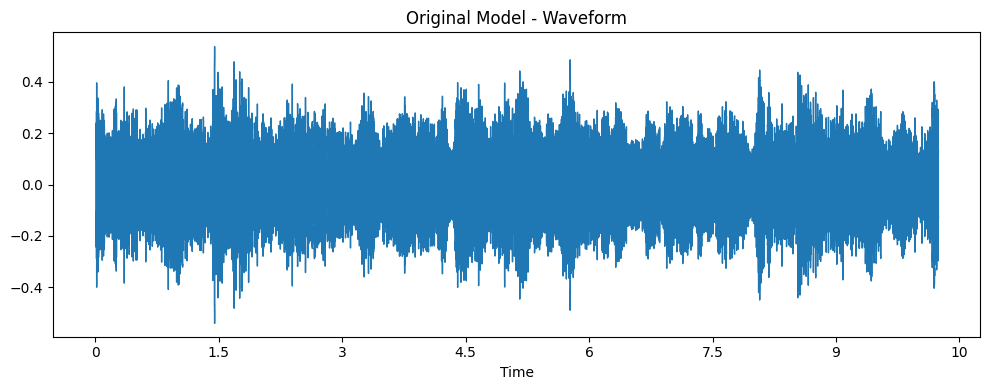

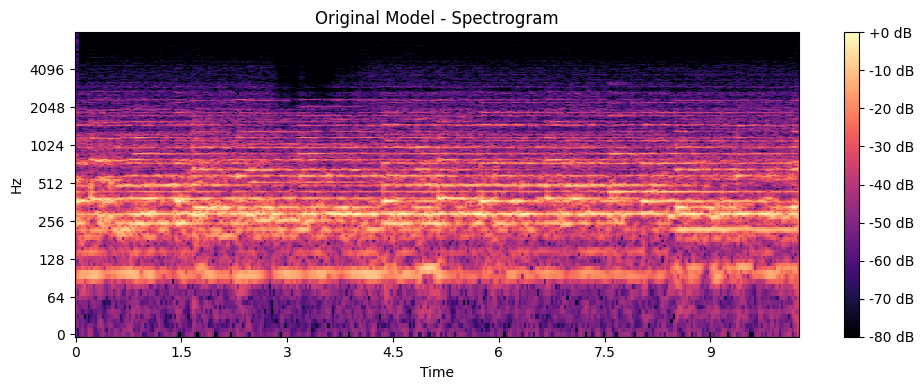

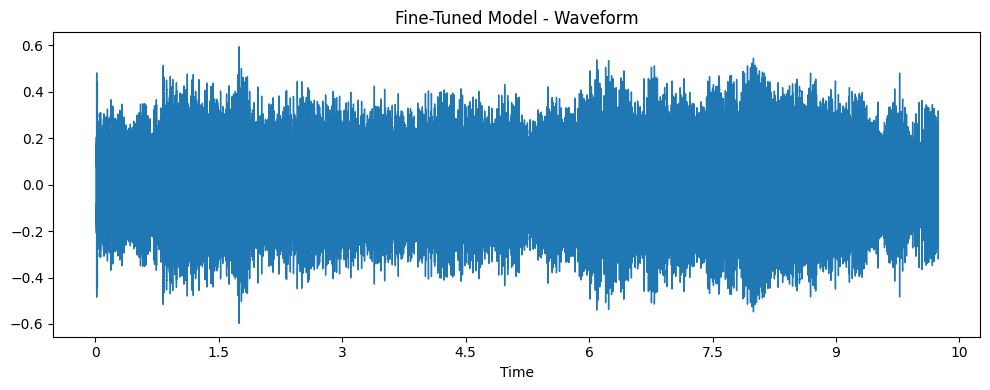

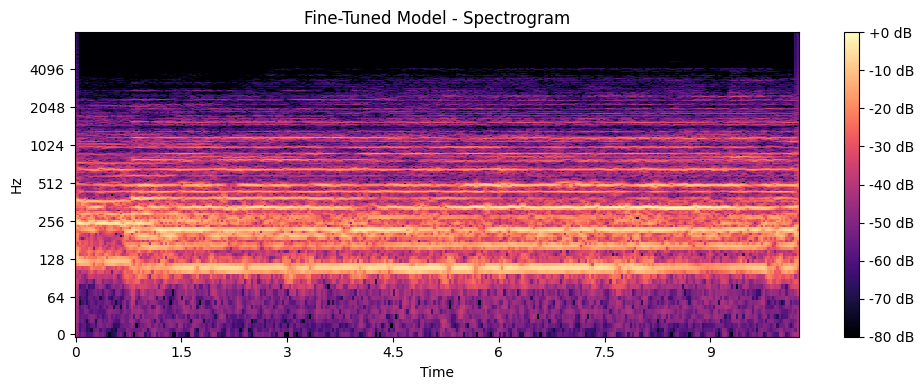

In [100]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

def plot_waveform(audio, title):
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=16000)
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_spectrogram(audio, title):
    D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(D, sr=16000, x_axis='time', y_axis='log')
    plt.title(title)
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()

# Plot for the first prompt
plot_waveform(original_audios[0], "Original Model - Waveform")
plot_spectrogram(original_audios[0], "Original Model - Spectrogram")

plot_waveform(fine_tuned_audios[0], "Fine-Tuned Model - Waveform")
plot_spectrogram(fine_tuned_audios[0], "Fine-Tuned Model - Spectrogram")


In [105]:
!pip install torchopenl3


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.6 MB/s eta 0:00:00
  Created wheel for julius: filename=julius-0.2.7-py3-none-any.whl size=21870 sha256=d1358df934ad39aab5934a375fceb075bcf94fce8e95fba38de771fe073f5702
  Stored in directory: /root/.cache/pip/wheels/b9/b2/05/f883527ffcb7f2ead5438a2c23439aa0c881eaa9a4c80256f4
Successfully built julius


In [117]:
import torchopenl3
import torch
import numpy as np
from scipy.spatial.distance import cosine

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load the model
model = torchopenl3.models.load_audio_embedding_model(
    input_repr="mel256",
    content_type="music",
    embedding_size=512,
)

def get_embedding(audio):
    # Ensure audio is a numpy array with shape (num_samples,)
    if len(audio.shape) > 1:
        audio = audio.squeeze()
    audio = audio.astype('float32')

    # torchopenl3 expects audio with shape (batch_size, num_samples)
    audio = np.expand_dims(audio, axis=0)

    emb, ts = torchopenl3.get_audio_embedding(
        audio,
        sr=16000,
        model=model,
        input_repr="mel256",
        content_type="music",
        embedding_size=512,
        center=True,
        hop_size=0.1,
        batch_size=1,
    )

    # If emb has shape (time_frames, embedding_size), average over time
    emb = emb.mean(axis=0)

    # Ensure emb is a 1-D array
    emb = emb.cpu().numpy().flatten()
    return emb


# Get embeddings for original audios
original_embeddings = [get_embedding(audio) for audio in original_audios]

# Get embeddings for fine-tuned audios
fine_tuned_embeddings = [get_embedding(audio) for audio in fine_tuned_audios]

# Compute similarities
for idx in range(len(text_prompts)):
    # After computing embeddings
    print(f"Original embedding {idx} shape: {original_embeddings[idx].shape}")
    print(f"Fine-tuned embedding {idx} shape: {fine_tuned_embeddings[idx].shape}")

    sim = 1 - cosine(original_embeddings[idx], fine_tuned_embeddings[idx])
    print(f"Prompt {idx+1} Embedding Similarity: {sim}")


Original embedding 0 shape: (50688,)
Fine-tuned embedding 0 shape: (50688,)
Prompt 1 Embedding Similarity: 0.979483652674113
Original embedding 1 shape: (50688,)
Fine-tuned embedding 1 shape: (50688,)
Prompt 2 Embedding Similarity: 0.9807383669880403
Original embedding 2 shape: (50688,)
Fine-tuned embedding 2 shape: (50688,)
Prompt 3 Embedding Similarity: 0.9696585062974019


In [118]:
!pip install pesq


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  Preparing metadata (setup.py) ... done
  Created wheel for pesq: filename=pesq-0.0.4-cp310-cp310-linux_x86_64.whl size=114934 sha256=7098f552ff115852530b11781f04d6092836797a473a736b2a53c627453a6d3d
  Stored in directory: /root/.cache/pip/wheels/c5/4e/2c/251524370c0fdd659e99639a0fbd0ca5a782c3aafcd456b28d
Successfully built pesq


In [126]:
from pesq import pesq
import numpy as np
import librosa

# Iterate through each pair of original and fine-tuned audio
for i in range(len(original_audios)):
    # Convert each audio sample to a NumPy array
    original_audio = np.array(original_audios[i])
    fine_tuned_audio = np.array(fine_tuned_audios[i])

    # Resample if the audio is not already at 16kHz
    original_audio, _ = librosa.resample(original_audio, orig_sr=44100, target_sr=16000), 16000
    fine_tuned_audio, _ = librosa.resample(fine_tuned_audio, orig_sr=44100, target_sr=16000), 16000

    # Ensure the audio is mono (if multi-channel, convert to mono)
    if original_audio.ndim > 1:
        original_audio = np.mean(original_audio, axis=1)
    if fine_tuned_audio.ndim > 1:
        fine_tuned_audio = np.mean(fine_tuned_audio, axis=1)

    # Ensure both arrays are the same length
    min_len = min(len(original_audio), len(fine_tuned_audio))
    original_audio = original_audio[:min_len]
    fine_tuned_audio = fine_tuned_audio[:min_len]

    # Compute PESQ score between original and fine-tuned audio
    pesq_score = pesq(16000, original_audio, fine_tuned_audio, 'wb')

    print(f"PESQ Score between original and fine-tuned for prompt {i+1}: {pesq_score}")

    

PESQ Score between original and fine-tuned for prompt 1: 1.1089038848876953
PESQ Score between original and fine-tuned for prompt 2: 1.0224615335464478
PESQ Score between original and fine-tuned for prompt 3: 1.0459022521972656


In [129]:
!pip install mir_eval


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.7/90.7 kB 2.2 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for mir_eval: filename=mir_eval-0.7-py3-none-any.whl size=100701 sha256=708793b38649dc05ab82392fbd20454449780e8c97e9792321caa1fc38e437be
  Stored in directory: /root/.cache/pip/wheels/3e/2f/0d/dda9c4c77a170e21356b6afa2f7d9bb078338634ba05d94e3f
Successfully built mir_eval


# SDR (Signal to Distortion Ratio)

+ Measures the amount of distortion or noise in the audio signal.
+ Higher SDR indicates cleaner audio output

In [130]:
import mir_eval

# Ensure both audios are the same length
original_audio = original_audio[:min_len]
fine_tuned_audio = fine_tuned_audio[:min_len]

# Compute SDR
sdr, _, _, _ = mir_eval.separation.bss_eval_sources(original_audio, fine_tuned_audio)
print(f"SDR between original and fine-tuned: {sdr[0]}")


SDR between original and fine-tuned: -19.42602163102129


# SSNR(Segmental Signal-to-Noise Ratio)

+ Measures how much noise is present in the audio signal relative to the clean signal.
+ Higher SSNR means less noise


In [131]:
def segmental_snr(clean_signal, noisy_signal, eps=1e-8):
    min_len = min(len(clean_signal), len(noisy_signal))
    clean_signal = clean_signal[:min_len]
    noisy_signal = noisy_signal[:min_len]
    diff = clean_signal - noisy_signal
    snr = 10 * np.log10(np.sum(clean_signal**2 + eps) / (np.sum(diff**2) + eps))
    return snr

ssnr_score = segmental_snr(original_audio, fine_tuned_audio)
print(f"SSNR between original and fine-tuned: {ssnr_score}")


SSNR between original and fine-tuned: -5.030454933338372


In [132]:
!pip install fastdtw librosa


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 2.5 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for fastdtw: filename=fastdtw-0.3.4-cp310-cp310-linux_x86_64.whl size=110015 sha256=d1a3283072a14ead2a8713d041422bc482c840f8971d353d6ad1ef9be10c6085
  Stored in directory: /root/.cache/pip/wheels/73/c8/f7/c25448dab74c3acf4848bc25d513c736bb93910277e1528ef4
Successfully built fastdtw


# MCD (Mel-Cepstral Distortion

+ Measures the distortion between two mel-cepstral coefficient (MCC) sequences.
+ Lower MCD means less distortion.


In [133]:
import librosa
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean

def mcd(original_audio, fine_tuned_audio):
    # Extract MFCC features
    mfcc_orig = librosa.feature.mfcc(y=original_audio, sr=16000, n_mfcc=13)
    mfcc_ft = librosa.feature.mfcc(y=fine_tuned_audio, sr=16000, n_mfcc=13)

    # Apply dynamic time warping (DTW)
    dist, _ = fastdtw(mfcc_orig.T, mfcc_ft.T, dist=euclidean)

    # Return normalized MCD score
    return dist / len(mfcc_orig.T)

mcd_score = mcd(original_audio, fine_tuned_audio)
print(f"MCD Score between original and fine-tuned: {mcd_score}")


MCD Score between original and fine-tuned: 190.65717167128798


# LSD(Log Spectral Distance)

+ Measures the log-distance between the power spectrums of the original and fine-tuned audio.
+ Lower LSD indicates better quality


In [134]:
def log_spectral_distance(original_audio, fine_tuned_audio, n_fft=1024):
    # Compute spectrograms
    S_orig = np.abs(librosa.stft(original_audio, n_fft=n_fft))**2
    S_ft = np.abs(librosa.stft(fine_tuned_audio, n_fft=n_fft))**2

    # Convert to dB scale
    log_S_orig = librosa.power_to_db(S_orig)
    log_S_ft = librosa.power_to_db(S_ft)

    # Compute log spectral distance
    lsd = np.mean(np.sqrt(np.mean((log_S_orig - log_S_ft)**2, axis=0)))
    return lsd

lsd_score = log_spectral_distance(original_audio, fine_tuned_audio)
print(f"LSD Score between original and fine-tuned: {lsd_score}")


LSD Score between original and fine-tuned: 18.623292922973633
